In [1]:
from scipy.io import loadmat
from sklearn.decomposition import PCA
import numpy as np
import pandas as pd
import networkx as nx
from keras.layers import Input, Dense, noise
from keras.models import Model
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [2]:
data_dir='./data/'

In [3]:
def scale_sim_mat(mat):
    mat  = mat - np.diag(np.diag(mat))
    D_inv = np.diag(np.reciprocal(np.sum(mat,axis=0)))
    mat = np.dot(D_inv,  mat)
    return mat

In [4]:
def get_data():
    '''
        获取数据
    '''
    label=loadmat(data_dir+'wine_label.mat')
    data=loadmat(data_dir+'wine_network.mat')
    label=label['wine_label']
    data=data['adjMat'].reshape(len(label),-1)
    #data=data/data.sum(axis=1).reshape(-1,1)
    data=scale_sim_mat(data)
    return data,label

In [5]:
data,label=get_data()

In [6]:
def random_surfing(matrix,alpha=0.98,steps=10):
    nodes_count=len(matrix)
    p0=np.eye(nodes_count,dtype='float64')
    result=np.zeros((nodes_count,nodes_count),dtype='float64')
    p=p0.copy()
    for i in range(steps):
        p=alpha*np.dot(p,matrix)+(1-alpha)*p0
        result=result+p
    #result=result/result.sum(axis=1).reshape(-1,1)
    result=scale_sim_mat(result)
    return result

In [7]:
def get_PPMI(matrix):
    
    node_counts=len(matrix)
    D=matrix.sum()
    row_sum=matrix.sum(axis=1).reshape(-1,1)
    column_sum=matrix.sum(axis=0).reshape(1,-1)
    PPMI=np.log(np.divide(D*matrix,np.dot(row_sum,column_sum)))
    PPMI[np.isnan(PPMI)]=0
    PPMI[np.isinf(PPMI)] = 0.0
    PPMI[np.isneginf(PPMI)] = 0.0
    PPMI[PPMI<0]=0
    return PPMI
    

In [8]:
def get_pca(data):

    pca = PCA(n_components=2)
    return pca.fit_transform(data)

In [9]:
A=get_PPMI(random_surfing(get_data()[0]))

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log
  import sys


In [10]:
def train(data,hidden_layer=3,hidden_neurons=[128,64,32]):
    input_layer=Input(shape=(data.shape[1],))
    encoder=noise.GaussianNoise(0.2)(input_layer)
    for i in range(hidden_layer):
        encoder=Dense(hidden_neurons[i],activation='relu')(encoder)
        encoder=noise.GaussianNoise(0.2)(encoder)
    decoder=Dense(hidden_neurons[-2],activation='relu')(encoder)
    for j in range(hidden_layer-3,-1,-1):
        decoder=Dense(hidden_neurons[j],activation='relu')(decoder)
    decoder=Dense(data.shape[1],activation='sigmoid')(decoder)

    sdae=Model(input=input_layer,output=decoder)
    sdae.summary()
    sdae.compile(optimizer='adadelta',loss='mse')
    sdae.fit(data,data,steps_per_epoch=20,epochs=10)
    return Model(input=input_layer,output=encoder)
        

In [11]:
encoder=train(A)

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 178)               0         
_________________________________________________________________
gaussian_noise_1 (GaussianNo (None, 178)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               22912     
_________________________________________________________________
gaussian_noise_2 (GaussianNo (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
gaussian_noise_3 (GaussianNo (None, 64)                0         
_________________________________________________________________
dens

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  if sys.path[0] == '':


Epoch 1/10
20/20 [==============================] - 0s 18ms/step - loss: 0.2347
Epoch 2/10
20/20 [==============================] - 0s 3ms/step - loss: 0.2113
Epoch 3/10
20/20 [==============================] - 0s 3ms/step - loss: 0.1106
Epoch 4/10
20/20 [==============================] - 0s 3ms/step - loss: 0.0071
Epoch 5/10
20/20 [==============================] - 0s 3ms/step - loss: 0.0012
Epoch 6/10
20/20 [==============================] - 0s 3ms/step - loss: 6.3192e-04
Epoch 7/10
20/20 [==============================] - 0s 3ms/step - loss: 4.0192e-04
Epoch 8/10
20/20 [==============================] - 0s 3ms/step - loss: 3.0561e-04
Epoch 9/10
20/20 [==============================] - 0s 3ms/step - loss: 2.4912e-04
Epoch 10/10
20/20 [==============================] - 0s 3ms/step - loss: 2.2447e-04


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:16: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("ga...)`
  app.launch_new_instance()


In [12]:
after=encoder.predict(A)
after=get_pca(after)

In [13]:
mean=after.mean(axis=0)
squre=np.sqrt(np.mean(np.power((after-mean),2)))

In [15]:
after=(after-mean)/squre

In [16]:
label=label.reshape(-1,)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/legend.py:1270: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  warnings.warn("You have mixed positional and keyword arguments, some "


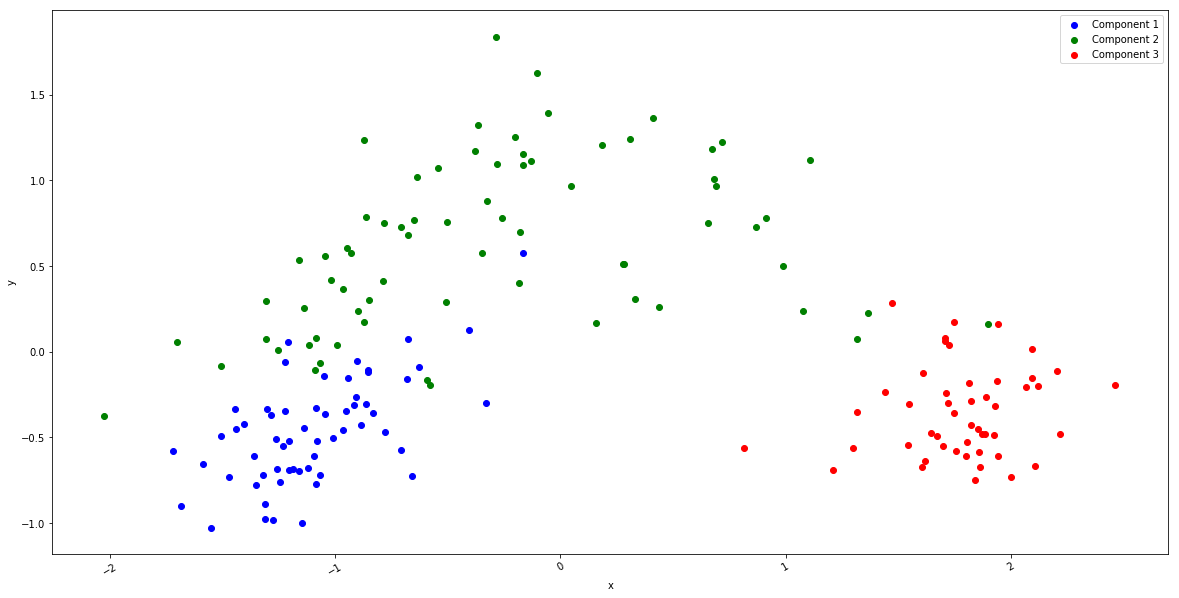

In [17]:

df_after=pd.DataFrame(after)
fig1 = plt.figure(1,figsize=(20,10))

colors = ['b','g','r']
Label_Com = ['Component 1','Component 2','Component 3']
for index in range(3):
    x = df_after.loc[label-1 == index][0]
    y = df_after.loc[label-1 == index][1]
    plt.scatter(x, y, c=colors[index])#, cmap='brg', s=40, marker='8')  

#plt.ylim(0.01,0.09)

ax = fig1.gca()
for label_ in ax.xaxis.get_ticklabels():
    label_.set_rotation(30)
plt.xlabel('x')
plt.ylabel('y')
#added this to get the legend to work
handles,labels = ax.get_legend_handles_labels()
ax.legend(handles, labels = Label_Com, loc='upper right')

plt.show()
plt.close()